# Equations

## Necessary imports

In [1]:
import math
import random
from scipy import *
import pandas

## Constants

In [2]:
ELRbase = 1600
SUPthreshold = 0.2
CELLShive = 250000
x1, x2, x3, x4, x5 = 385, 30, 36, 155, 30
LIFESPANegg = 3
LIFESPANlarva = 5
LIFESPANpupa = 12
MORTALITYeggs = 0.03
MORTALITYlarvae = 0.01
MORTALITYpupae = 0.001
CANNIBALISMhungerbase = [0.23, 0.3, 0.58, 0.06, 0] # for i in [1,2,...,5]
MORTALITYbase = 0.01
MORTALITYnursing = 0.005
MORTALITYprocessing = 0.005
MORTALITYforaging = 0.035
LOADpollenforager = 0.06
LOADnectarforager = 0.04
TURNSnectarforager = 15
TURNSpollenforager = 10
FACTORforagingsuccess = 0.8
FACTORminpollenforagers = 0.01
FACTORforagingmax = 0.33
ProcessorsPerCell = 2
FACTORpollenstorage = 6
FACTORpollensavingmax = 0.3
RATIOnectar_to_honey = 0.4 # 20/50
w_nectar = 0.43
w_pollen = 0.23
w_cellsbase = 0.037
w_honey = 0.5
w_egg = 0.0001
w_pupa = 0.16
w_adult = 0.1
w_larva = [0.0002,0.00059, 0.00331, 0.0644, 0.160] # for i in [1,...,5]
w_hivebase = 14000 #("14,000g")

#######Creations des tableaux
STORESpollenTab = zeros(366)
STOREShoneyTab = zeros(366)
STORESnectarTab = zeros(366)
BroodCellsTab = zeros(366)
BEESadultTab = zeros(366)
WEIGHTcolonyTab = zeros(366)
t = arange(366)

####### Initialisation des valeurs à 0
STORESpollenTab[0] = 0
STOREShoneyTab[0] = 50000
STORESnectarTab[0] = 0
BroodCellsTab[0] = 0
BEESadultTab[0] = 15000
WEIGHTcolonyTab[0] = 50

####### Creation du dataframe
ar = numpy.array([STORESpollenTab,STOREShoneyTab,STORESnectarTab,BroodCellsTab,BEESadultTab,WEIGHTcolonyTab])
dFResult= pandas.DataFrame(ar, index = t, columns = ['STORESpollen', 'STOREShoney', 'STORESnectar', 'BroodCells','BEESadult','WEIGHTcolony'])


## 2.1.   Modeling the queen’s egg laying behavior

In [3]:
def season(t):
    # (1)
    return max(1-(1/(1+x1*math.exp(-2*t/x2))),1/(1+x3*math.exp(-2*(t-x4)/x5)))

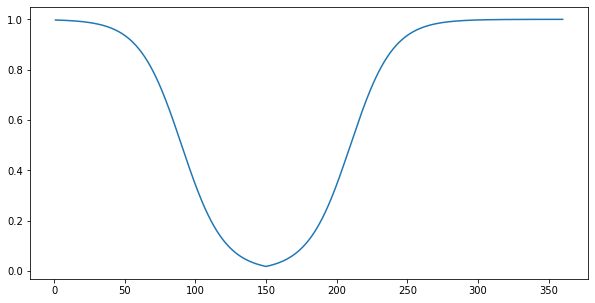

In [86]:
import matplotlib.pyplot as plt
import numpy as np

graph = []

for i in range(360):
    graph.append(season(i))

plt.figure(figsize=(10,5))
plt.plot(np.linspace(1,360, 360), graph)

In [113]:
#Manque condition sur t
def CELLSempty(t):
    # (2)
    if t=0 : 
        return 0
    return CELLShive - CELLSbrood(t) - STORESpollen(t) - STORESnectar(t) - STOREShoney(t)

SyntaxError: invalid syntax (<ipython-input-113-975154b8e1c0>, line 4)

In [5]:
def SUPcomb(t):
    # (3)
    if CELLSempty(t)/(CELLShive + 1) < SUPthreshold:
        return CELLSempty(t)/((CELLShive + 1) * SUPthreshold)
    else:
        return 1

In [90]:
def ELRstoch(t):
    # (4)
    return random.uniform(1000,2000)

In [7]:
#Problème récursion infinie

def ELR(t):
    # (5)
    return ELRbase * (1 + ELRstoch(t)) * (1 - season(t)) * SUPcomb(t) 

## 2.2. Modeling the immature stages

### 2.2.1 Eggs

In [8]:
def EGGS(i,t):
    # (6)
    if i == 1:
        return ELR(t-1) * (1 - MORTALITYeggs)
    elif i in [2,3]:
        return EGGS(i-1,t-1) * (1 - MORTALITYeggs) 

In [109]:
#ERREUR ICI
def CELLSeggs(t):
    # (7)
    sum = 0
    for i in range(LIFESPANegg+1):
        if i != 0:
            sum += EGGS(i,t)
    return sum

In [108]:
def CELLSeggs(t):
    # (8)
    # alternative to (7)
    sum = 0
    for i in range(LIFESPANegg+1):
        if i != 0:
            sum += (ELR(t-i)*math.pow(1-MORTALITYeggs,i))
    return sum

### 2.2.2. Larvae (unsealed)

In [11]:
def SURVIVALlarvae(i,t):
    # (9)
    return (1 - CANNIBALISMlarvae(i,t)) * (1 - MORTALITYlarvae)

In [12]:
def CANNIBALISMlarvae(i,t):
    # (10)
    return CANNIBALISMhungerbase(i) * (1 - (INDEXpollensituation(t-1) * INDEXnursingquality(t-1)))

In [13]:
def LARVAE(i,t):
    # (11)
    if i == 1:
        return EGGS(LIFESPANegg,t-1)*SURVIVALlarvae(1,t)
    elif 1 < i and i <= LIFESPANlarva:
        return LARVAE(i-1,t-1) * SURVIVALlarvae(i,t)

In [14]:
def CELLSlarvae(t):
    # (12)
    sum = 0
    for i in range(LIFESPANlarva+1):
        if i != 0:
            sum += LARVAE((i,t))
    return sum 

In [15]:
def CELLSlarvae(t):
    # (13)
    # alternative to (12)
    
    def product(i):
        prdct = 1
        for k in range(i+1):
            if k != 0:
                prdct *= SURVIVALlarvae(k,t-i+k)
        return prdct
    
    sum = 0
    for i in range(LIFESPANlarva+1):
        if i != 0:
            sum += (ELR(t-i-LIFESPANegg)*math.pow(1-MORTALITYeggs,i)*product(i))  
    
    return sum

In [16]:
def PUPAE(i,t):
    # (14)
    if i == 1:
        return LARVAE(LIFESPANlarva,t-1) * (1 - MORTALITYpupae)
    elif 1 < i and i <= LIFESPANpupa:
        return PUPAE(i-1,t-1) * (1 - MORTALITYpupae)

In [17]:
def CELLSpupae(t):
    # (15)
    sum = 0
    for i in range(LIFESPANpupa+1):
        if i != 0:
            sum += PUPAE((i,t))
    return sum 

In [18]:
def CELLSpupae(t):
    # (16)
    # alternative to (15)
    
    def product(i):
        prdct = 1
        for k in range(LIFESPANlarva+1):
            if k != 0:
                prdct *= SURVIVALlarvae(k,t-i-LIFESPANlarva+k)
        return prdct
    
    sum = 0
    for i in range(LIFESPANpupa+1):
        if i != 0:
            sum += (ELR(t-i-LIFESPANegg-LIFESPANlarva)*math.pow(1-MORTALITYeggs,LIFESPANegg)*product(i)*math.pow(1-MORTALITYpupae,i))  
    
    return sum

In [19]:
def CELLSbrood(t):
    # (17)
    return CELLSeggs(t) + CELLSlarvae(t) + CELLSpupae(t)

## 2.3 Modeling the population of adult bees

In [20]:
def MORTALITYadult(t) :
    # (18)
	res = MORTALITYadultbase
	res += (MORTALITYnursing * NURSES(t - 1) / BEESadult(t - 1) + 1)
	res += (MORTALITYprocessing * PROCESSORS(t - 1) / BEESadult(t - 1) + 1)
	res += (MORTALITYforaging * FORAGERSactive(t - 1) / BEESadult(t - 1) + 1)
	return res

In [21]:
def BEESadult(t) : 
    # (19)
	res = dFResult.loc[dFResult.index[t],'BEESadult'] + PUPAE(LIFESPANpupa, t - 1)) * (1 - MORTALITYadult(t))
	return res

## 2.4 Modeling the influence of the environment

In [22]:
def INDEXrain(t) :
    # (20)
	return (1 - RAIN(t))

In [23]:
def RAIN(t) :
    # (21)
	res = HOURSraining_during_daylight(t) / HOURSdaylight(t)
	return res

In [24]:
def INDEXtemperature(t) :
    # (22)
	if ((TEMP(t) <= 14) or (TEMP(t) > 40)) :
		res = 0
	elif (TEMP(t) <= 22) :
		res = (TEMP(t) - 14) / 8
	elif (TEMP(t) <= 32) : 
		res = 1
	else : 
		res = (40 - TEMP(t)) / 8 

	return res

In [25]:
def INDEXflight(t) : 
    # (23)
	return (INDEXrain(t) * INDEXtemperature(t))

In [26]:
def INDEXnectaroutside(t) :
    # (24)
	return min((1 - season(t)) * 1.5, 1)

In [27]:
def INDEXpollenoutside(t) :
    # (25)
	return min((1 - season(t)) * 1.5, 1)

## 2.5 Modeling task decisions

In [28]:
def NEEDworkers(t):
    # (26)
    return NEEDnurses(t) + NEEDpollenforagers(t)

In [29]:
def RATIOworkforce(t, FACTORothertasks = 0.2):
    # (27)
    return min(BEESadult(t) * (1 - FACTORothertasks) / (NEEDWORKERS(t) + 1), 1)

## 2.6 Modeling the regulation of nursing

In [30]:
def NEEDnurses(t):
    # (28)
    res = 0
    for i in range(1, LIFESPANlarva):
        res = LARVAE(i, t) * NEEDnurses_per_larva(i)
    return res + CELLSeggs(t) * NEEDnursesperegg + CELLSpupae(t) * NEEDnursesperpupa

In [31]:
def NURSES(t):
    # (29)
    return NEEDworkers(t) + RATIOworkforce(t)

In [32]:
def INDEXnursingquality(t):
    # (30)
    return NURSES(t)/(NEEDnurses(t) + 1)

## 2.7 Modeling the regulation of foraging

In [33]:
def FORAGERS(t):
    # (31) represents the available workforce for the foraging task.
    res = FORAGERSpollen(t)+FORAGERSnectaractive(t)
    return(res)

In [34]:
def FORAGERSactive(t):
    # (32) represents the actual number of foragers that fly out
    res = FORAGERSpollenactive(t)+FORAGERSnectaractive(t)
    return(res)

### 2.7.1 Recruitment of pollen foragers

In [35]:
def NEEDpollen(t):
    # (33) calculate the colony’s pollen demand
    res = NEEDpollen_larvae(t)+NEEDpollen_adult(t)
    return(res)

In [36]:
def NEEDpollen_larvae(t):
    # (34) represents the pollen demand of larvae of all ages
    result = 0
    for i in range(1,LIFESPANlarva):
        S+= (PELLENNEEDlarva(i)*(LARVAE(i,t)))
    return(result)

In [37]:
def NEEDpollen_adult(t):
    # (35) represents the adult’s pollen demand
    result = BEESadult(t) * POLLENNEEDadult + NURSES(t) * POLLENNEEDnurse
    return(result)

In [38]:
def NEEDpollenincome(t):
    # (36) represents the daily need for pollen income
    S = 0
    for i in range(0,2):
        S += NEEDpollen(t - d)
    tmp = S/3 * FACTORpollenstorage - STORESpollen(t)
    result = max(0,tmp)
    return(result)

In [39]:
def NEEDpollenforagers(t):
    # (37) models the number of pollen foragers needed according to the current need for additional pollen.
    result = NEEDpollenincome(t-1) / (LOADpollenforager * TURNSpollenforager * FACTORforagingsuccess)
    return(result)

In [40]:
def FORAGERSpollen(t):
    # (38) models the potential number of pollen foragers each day
    max1 = NEEDpollenforagers(t) * RATIOworkforce(t)
    max2 = (BEESadult(t)-NURSES(t))*FACTORminpollenforagers
    min1 = max(max1,max2)
    min2 = BEESadult(t) * FACTORforagingmax
    result = min(min1,min2)
    return(result)

In [41]:
def FORAGERSpollenactive(t):
    # (39) models the number of foragers that actually leave the hive for foraging flights
    result = FORAGERpollen(t) * INDEXflight(t) * INDEXpollenoutside(t)
    return(result)

### 2.7.2 Recruitment of nectar foragers

In [42]:
def NEEDnectar(t):
    # (40) model the demand for nectar
    result = NEEDnectar_larvae(t) + NEEDnectar_adult(t)
    return(result)

In [43]:
def NEEDnectar_larvae(t):
    # (41) model the demand for larvae nectar
    result = 0
    for i in range(1,LIFESPANlarva):
        result += NECTARNEEDlarva(i) * LARVAE(i,t)
    return(result)

In [44]:
def NEEDnectar_adult(t):
    # (42)model the demand for adult nectar
    result = BEESadult(t) * NECTARNEEDadult + NURSES(t) * NECTARNEEDnurse + FORAGESactive(t) * NECTARNEEDactiveforager
    return(result)

In [45]:
def WORKFORCEnectar(t):
    # (43) calculates the number of adult bees that are not involved in other tasks and thus are still available for a task associated with nectar collection
    result = 0
    if (RATIOworkforce(t) == 1):
        result = (BEESadult(t) * (1 - FACTORothertasks)) - NURSES(t) - FORAGERSpollen(t)
    return(result)

In [46]:
def FORAGERSnectar(t):
    # (44) models the number of potential nectar foragers
    min1 = (BEESadult(t) * FACTORforagingmax) - FORAGERSpollen(t)
    min2 = WORKFORCEnectar(t) - PROCESSORS(t)
    result = min(min1,min2)
    return(result)

In [47]:
def FORAGERSnectaractive(t): 
    # (45) models the number of nectar foragers that actually leave the hive for foraging flights
    result = FORAGERSnectar(t) * INDEXflight(t) * INDEXnectaroutside(t)
    return(result)

## 2.8 Modeling the resource influx into the colony

In [48]:
def INCOMEpollen(t):
    # (46) project the daily influx of pollen
    result = FORAGERpollenactive(t) * LOADpollenforager * TURNSpollenforager * FACTORforagingstoch(t) * FACTORforagingsuccess
    return(result)

In [49]:
def FACTORforagingstoch(t):
    # (47) used to vary the daily foraging success symmetrically around 1
    if (stochastic_factor > 0.24 and stochastic_factor < 0.26):
        result = random.randint(75,125) /100
    else:
        result = 1
    return(result)

In [50]:
def INDEXpollensituation(t):
    # (48) describes the level of the pollen stores in relation to the demand situation of the colony
    min1 = STORESpollen(t) / (NEEDpollen(t) * FACTORpollenstorage + 1)
    result = min(1,min1)
    return(result)

In [51]:
def INCOMEnectar(t):
    # (49) project the daily influx of nectar
    min1 = FORAGERSnectaractive(t) * LOADnectarforager * TURNSnectarforager * FACTORforagingstoch(t) * FACTORforagingsuccess
    min2 = CELLSempty(t - 1)
    result = min(min1,min2)
    return(result)

## 2.9 Regulation of food processing

In [52]:
#Needed nectar processors on day t
def NEEDprocessors(t):
    #(50)
    result = STORESnectar(t-1)*ProcessorsPerCell
    return(result)

In [53]:
def PROCESSORS(t):
    #(51)
    result = min(NEEDprocessors(t), WORKFOREnectar(t))
    return(result)

In [54]:
def PROCESSEDnectar(t):
    #(52)
    result = min(STORESnectar(t-1)-USAGEnectar(t), PROCESSORS(t)/ProcessorsPerCell)
    return(result)

## 2.10 Management of nutrient stores

In [55]:
#The daily usage (consumption) of pollen
def USAGEpollen(t):
    #(53)
    result = min(STORESpollen(t-1), NEEDpollen(t-1)*(1-(FACTORpollensavingmax*(1-INDEXpollensituation(t-1)))))
    return(result)

In [56]:
#The daily amount of stored pollen
def STORESpollen(t):
    #(54)
    result = dFResult.loc[dFResult.index[t],'STORESpollen'] + INCOMEpollen(t) - USAGEpollen(t)
    return(result)

In [57]:
def USAGEnectar(t):
    #(55)
    result = min(STORESnectar(t-1), NEEDnectar(t))
    return(result)

In [58]:
def USAGEhoney(t):
    #(56)
    result = min(STOREShoney(t-1), (NEEDnectar(t)-USAGEnectar(t))*RATIOnectar_to_honey)
    return(result)

In [59]:
def STORESnectar(t):
    #(57)
    result = dFResult.loc[dFResult.index[t],'STORESnectar']+INCOMEnectar(t) - USAGEnectar(t)-PROCESSEDnectar(t)
    return(result)

In [67]:
def STOREShoney(t):
    #(58)
    result = dFResult.loc[dFResult.index[t],'STOREShoney']-USAGEhoney(t)+(PROCESSEDnecta(t)*RATIOnectar_to_honey)
    return(result)

In [68]:
def WEIGHTcolony(t):
    #(59)
    res = 0
    for i in range(1, LIFESPANlarva):
        res = res + (w_larva[i]*LARVAE(i,t))
    
    result = 1/1000*(w_hivebase+w_cellsbase*CELLShive+w_pollen*STORESpollen(t)
            +w_honey*STOREShoney(t)+w_egg*CELLSeggs(t)
            +w_pupa*CELLSpupae(t)
            +res
            +w_adult*BEEadult(t))
    return(result)

In [69]:
def BEESlazy(t):
    #(60)
    result = (BEESadult(t)*(1-FACTORothertasks))-FORAGERSactive(t)-NURSES(t)-PROCESSORS(t)
    return(result)